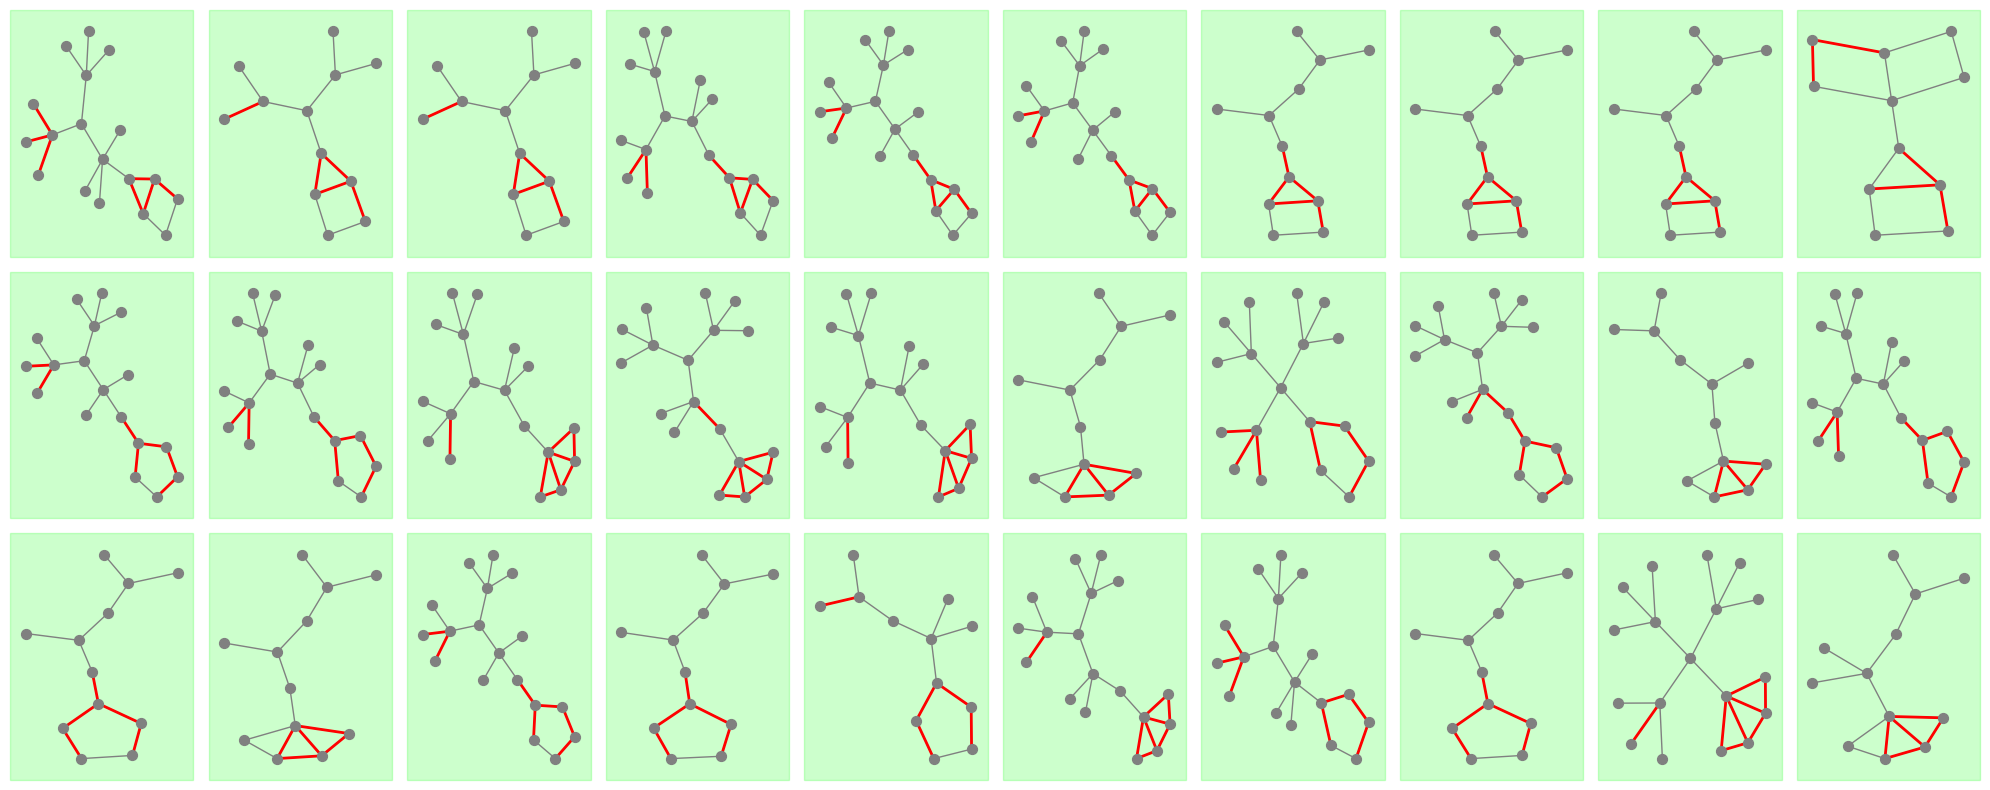

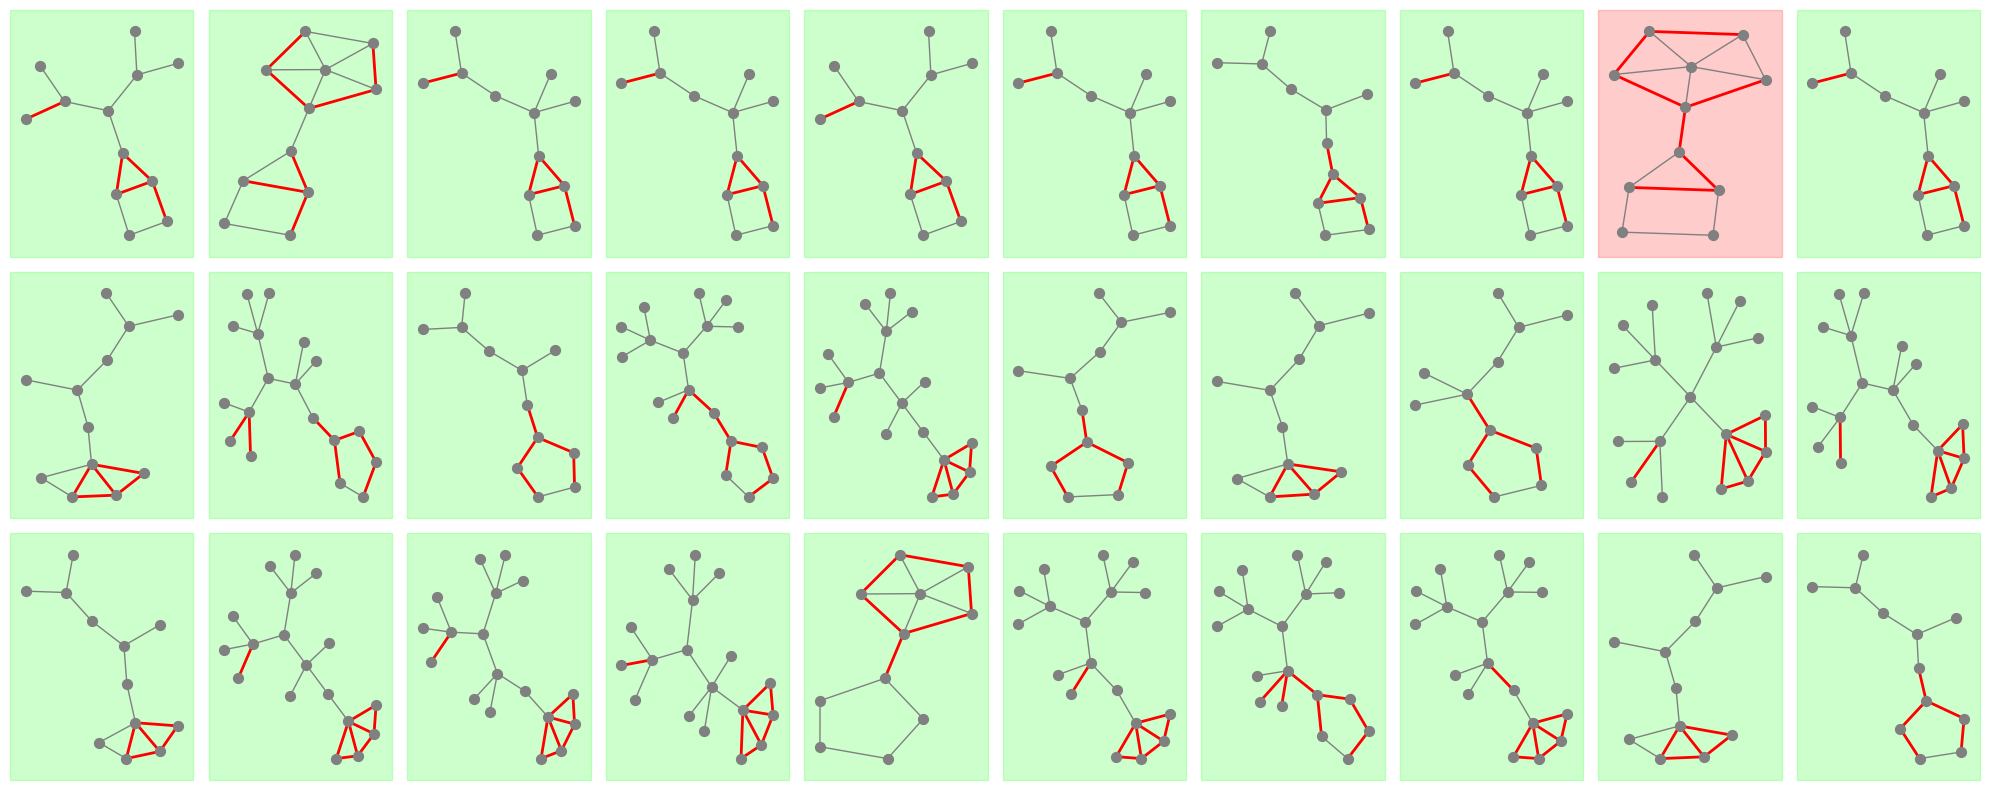

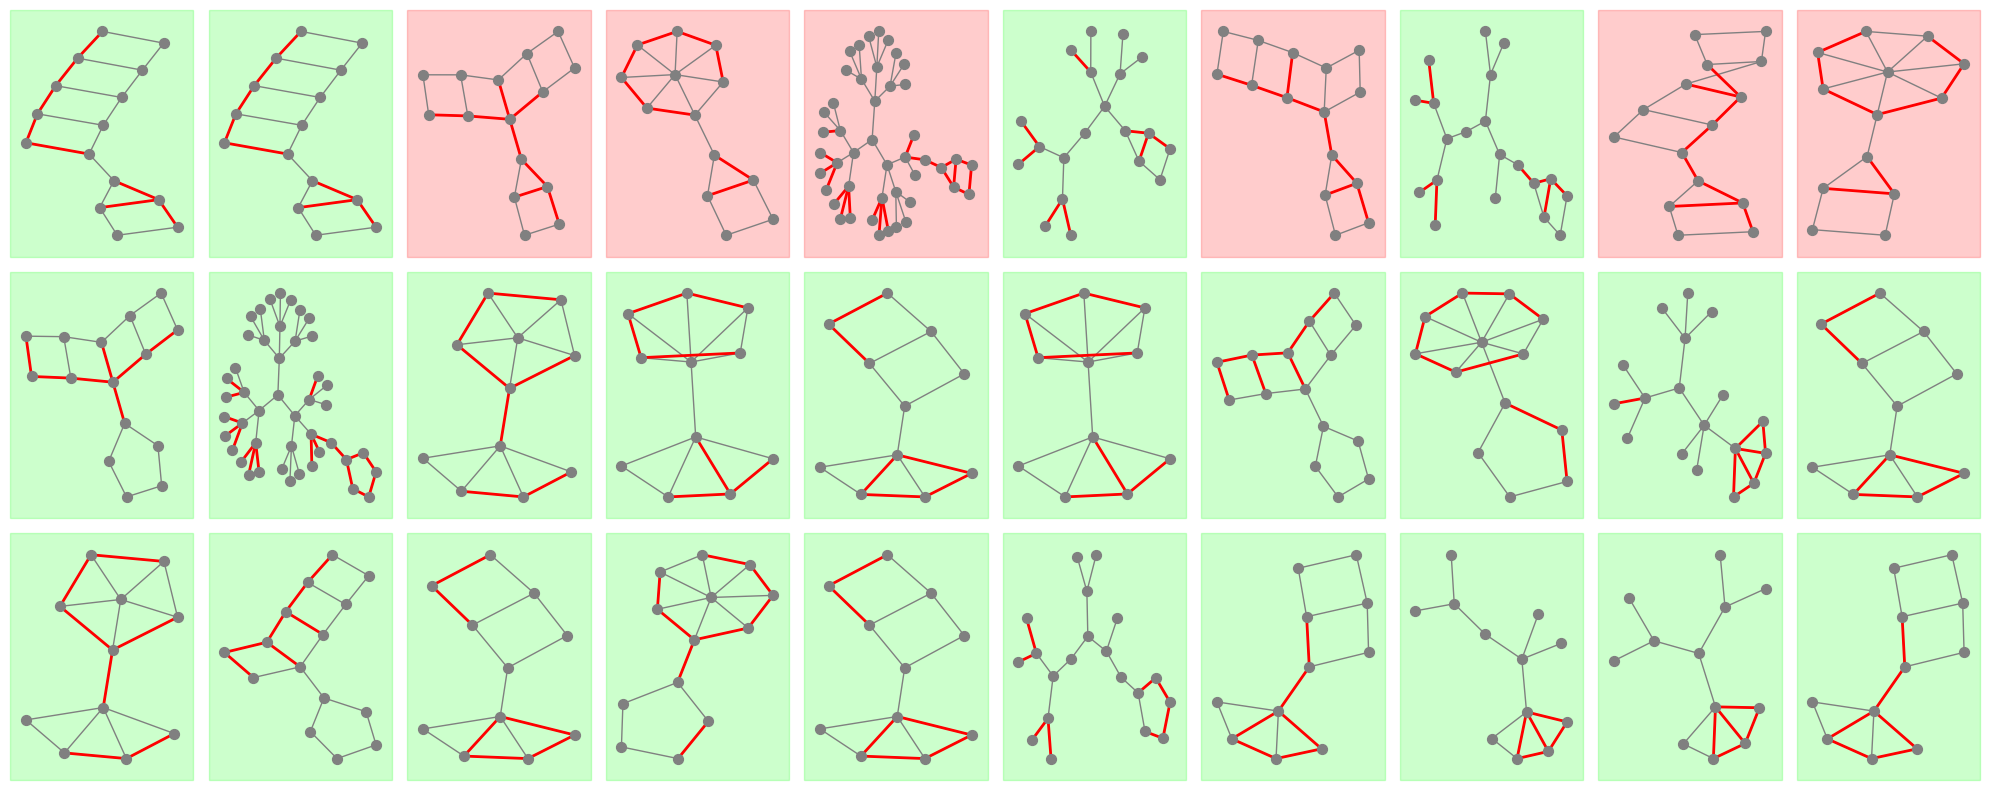

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GraphConv, BatchNorm, global_mean_pool
import random



class Predictor(torch.nn.Module):
    def __init__(self, in_channels, hid_channels=64, num_outputs=1, conv_unit=3):
        super(Predictor, self).__init__()
        self.node_emb = nn.Linear(in_channels, hid_channels)
        self.hid_channels = hid_channels
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.relus = nn.ModuleList()

        for _ in range(conv_unit):
            conv = GraphConv(in_channels=hid_channels, out_channels=hid_channels)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(hid_channels))
            self.relus.append(nn.ReLU())

        self.causal_mlp = nn.Sequential(
            nn.Linear(hid_channels, 2 * hid_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(2 * hid_channels, hid_channels),
            nn.ReLU(),
            nn.Linear(hid_channels, num_outputs),
        )

    def forward(self, x, edge_index, edge_attr, batch):
        node_x = self.get_node_reps(x, edge_index, edge_attr)
        graph_x = global_mean_pool(node_x, batch)
        logits = self.get_causal_pred(graph_x)
        return (logits > 0).float()

    def get_node_reps(self, x, edge_index, edge_attr):
        edge_weight = edge_attr.view(-1) if edge_attr is not None else None

        if x.size(1) != self.hid_channels:
            x = self.node_emb(x)

        for conv, batch_norm, relu in zip(self.convs, self.batch_norms, self.relus):
            if edge_weight is not None:
                x = conv(x, edge_index, edge_weight=edge_weight)
            else:
                x = conv(x, edge_index)
            x = relu(batch_norm(x))
        return x

    def get_causal_pred(self, causal_graph_x):
        pred = self.causal_mlp(causal_graph_x)
        return pred



class Rationale_Generator(torch.nn.Module):
    def __init__(self, in_channels, causal_ratio, channels=64):
        super(Rationale_Generator, self).__init__()

        self.conv1 = GraphConv(in_channels=in_channels, out_channels=channels)
        self.conv2 = GraphConv(in_channels=channels, out_channels=channels)
        self.mlp = nn.Sequential(
            nn.Linear(channels * 2, channels * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(channels * 4, 1),
        )
        self.ratio = causal_ratio

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)

        row, col = data.edge_index
        edge_rep = torch.cat([x[row], x[col]], dim=-1)
        edge_score = self.mlp(edge_rep).view(-1)

        return x, edge_score



def load_graphs(pt_path):
    return torch.load(pt_path, weights_only=False)


def relabel(x, edge_index, batch=None, pos=None):
    if edge_index.numel() == 0:
        empty_batch = batch[:0] if batch is not None else torch.zeros(0, dtype=torch.long, device=x.device)
        return x[:0], edge_index, empty_batch, pos
    
    num_nodes = x.size(0)
    sub_nodes = torch.unique(edge_index)
    x = x[sub_nodes]
    
    if batch is None:
        batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
    else:
        batch = batch[sub_nodes]
    
    row, col = edge_index
    node_idx = row.new_full((num_nodes,), -1)
    node_idx[sub_nodes] = torch.arange(sub_nodes.size(0), device=row.device)
    edge_index = node_idx[edge_index]
    
    if pos is not None:
        pos = pos[sub_nodes]
    
    return x, edge_index, batch, pos


def plot_graphs_separated_by_label(
    graph_list, rationale_generator, predictor, device, title, n_graphs=10
):
    plt.figure(figsize=(20, 8))

    graphs_label_1 = [g for g in graph_list if g.y.item() == 1]
    graphs_label_0 = [g for g in graph_list if g.y.item() == 0]

    selected_label_1 = random.sample(graphs_label_1, min(n_graphs, len(graphs_label_1)))
    
    selected_label_0_row2 = random.sample(graphs_label_0, min(n_graphs, len(graphs_label_0)))
    
    remaining_label_0 = [g for g in graphs_label_0 if g not in selected_label_0_row2]
    selected_label_0_row3 = random.sample(remaining_label_0, min(n_graphs, len(remaining_label_0)))

    for i, graph in enumerate(selected_label_1):
        graph = graph.to(device)
        x, edge_score = rationale_generator(graph)
        n_reserve = max(1, int(rationale_generator.ratio * edge_score.size(0)))
        _, idx_reserve = torch.topk(edge_score, n_reserve)
        causal_edges = [
            (graph.edge_index[0][j].item(), graph.edge_index[1][j].item())
            for j in idx_reserve
        ]

        G = to_networkx(graph, to_undirected=True)
        pos = nx.kamada_kawai_layout(G)

        ax = plt.subplot(3, n_graphs, i + 1)

        causal_edge_index = graph.edge_index[:, idx_reserve]
        
        causal_x, causal_edge_index_relabeled, causal_batch, _ = relabel(
            graph.x, causal_edge_index, batch=None
        )
        
        edge_attr = torch.ones(causal_edge_index_relabeled.size(1), 1).to(device)
        
        with torch.no_grad():
            node_reps = predictor.get_node_reps(
                x=causal_x,
                edge_index=causal_edge_index_relabeled,
                edge_attr=edge_attr
            )
            graph_rep = global_mean_pool(node_reps, causal_batch)
            out = predictor.get_causal_pred(graph_rep)
            pred_val = out.item() if out.numel() == 1 else out.mean().item()

        color = "#00FF00" if int(graph.y.item()) == int(pred_val > 0) else "#FF0000"
        rect = patches.Rectangle(
            (0, 0),
            1, 1,
            transform=ax.transAxes,
            color=color,
            alpha=0.2,
            zorder=0,
            clip_on=False
        )
        ax.add_patch(rect)

        node_labels = {
            node: str(int(graph.x[node].item())) for node in range(graph.num_nodes)
        }

        nx.draw(
            G,
            pos,
            node_color="gray",
            edge_color="gray",
            node_size=50,
            labels=node_labels,
            with_labels=False,
            ax=ax,
        )
        nx.draw_networkx_edges(
            G, pos, edgelist=causal_edges, edge_color="red", width=2, ax=ax
        )

    for i, graph in enumerate(selected_label_0_row2):
        graph = graph.to(device)
        x, edge_score = rationale_generator(graph)
        n_reserve = max(1, int(rationale_generator.ratio * edge_score.size(0)))
        _, idx_reserve = torch.topk(edge_score, n_reserve)
        causal_edges = [
            (graph.edge_index[0][j].item(), graph.edge_index[1][j].item())
            for j in idx_reserve
        ]

        G = to_networkx(graph, to_undirected=True)
        pos = nx.kamada_kawai_layout(G)

        ax = plt.subplot(3, n_graphs, n_graphs + i + 1)

        causal_edge_index = graph.edge_index[:, idx_reserve]
        
        causal_x, causal_edge_index_relabeled, causal_batch, _ = relabel(
            graph.x, causal_edge_index, batch=None
        )
        
        edge_attr = torch.ones(causal_edge_index_relabeled.size(1), 1).to(device)
        
        with torch.no_grad():
            node_reps = predictor.get_node_reps(
                x=causal_x,
                edge_index=causal_edge_index_relabeled,
                edge_attr=edge_attr
            )
            graph_rep = global_mean_pool(node_reps, causal_batch)
            out = predictor.get_causal_pred(graph_rep)
            pred_val = out.item() if out.numel() == 1 else out.mean().item()

        color = "#00FF00" if int(graph.y.item()) == int(pred_val > 0) else "#FF0000"
        rect = patches.Rectangle(
            (0, 0),
            1, 1,
            transform=ax.transAxes,
            color=color,
            alpha=0.2,
            zorder=0,
            clip_on=False
        )
        ax.add_patch(rect)

        node_labels = {
            node: str(int(graph.x[node].item())) for node in range(graph.num_nodes)
        }

        nx.draw(
            G,
            pos,
            node_color="gray",
            edge_color="gray",
            node_size=50,
            labels=node_labels,
            with_labels=False,
            ax=ax,
        )
        nx.draw_networkx_edges(
            G, pos, edgelist=causal_edges, edge_color="red", width=2, ax=ax
        )

    for i, graph in enumerate(selected_label_0_row3):
        graph = graph.to(device)
        x, edge_score = rationale_generator(graph)
        n_reserve = max(1, int(rationale_generator.ratio * edge_score.size(0)))
        _, idx_reserve = torch.topk(edge_score, n_reserve)
        causal_edges = [
            (graph.edge_index[0][j].item(), graph.edge_index[1][j].item())
            for j in idx_reserve
        ]

        G = to_networkx(graph, to_undirected=True)
        pos = nx.kamada_kawai_layout(G)

        ax = plt.subplot(3, n_graphs, 2 * n_graphs + i + 1)

        causal_edge_index = graph.edge_index[:, idx_reserve]
        
        causal_x, causal_edge_index_relabeled, causal_batch, _ = relabel(
            graph.x, causal_edge_index, batch=None
        )
        
        edge_attr = torch.ones(causal_edge_index_relabeled.size(1), 1).to(device)
        
        with torch.no_grad():
            node_reps = predictor.get_node_reps(
                x=causal_x,
                edge_index=causal_edge_index_relabeled,
                edge_attr=edge_attr
            )
            graph_rep = global_mean_pool(node_reps, causal_batch)
            out = predictor.get_causal_pred(graph_rep)
            pred_val = out.item() if out.numel() == 1 else out.mean().item()

        color = "#00FF00" if int(graph.y.item()) == int(pred_val > 0) else "#FF0000"
        rect = patches.Rectangle(
            (0, 0),
            1, 1,
            transform=ax.transAxes,
            color=color,
            alpha=0.2,
            zorder=0,
            clip_on=False
        )
        ax.add_patch(rect)

        node_labels = {
            node: str(int(graph.x[node].item())) for node in range(graph.num_nodes)
        }

        nx.draw(
            G,
            pos,
            node_color="gray",
            edge_color="gray",
            node_size=50,
            labels=node_labels,
            with_labels=False,
            ax=ax,
        )
        nx.draw_networkx_edges(
            G, pos, edgelist=causal_edges, edge_color="red", width=2, ax=ax
        )

    plt.tight_layout()
    plt.show()



def main():
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")

    rationale_generator_path = "../DIR_results/I_Hardly_Biased_Base/rationale_generator.pt"
    predictor_path = "../DIR_results/I_Hardly_Biased_Base/predictor.pt"

    train_path = "../data/I_Hardly_Biased_Base/train.pt"
    val_path = "../data/I_Hardly_Biased_Base/val.pt"
    test_path = "../data/I_Hardly_Biased_Base/test.pt"

    train_graphs = load_graphs(train_path)
    val_graphs = load_graphs(val_path)
    test_graphs = load_graphs(test_path)

    in_channels = train_graphs[0].x.size(1)

    rationale_generator = Rationale_Generator(
        in_channels, causal_ratio=0.42, channels=64
    ).to(device)
    predictor = Predictor(in_channels, hid_channels=64, num_outputs=1).to(device)

    rationale_generator.load_state_dict(
        torch.load(rationale_generator_path, map_location=device)
    )
    rationale_generator.eval()
    predictor.load_state_dict(torch.load(predictor_path, map_location=device))
    predictor.eval()

    plot_graphs_separated_by_label(
        train_graphs, rationale_generator, predictor, device, "Train"
    )
    plot_graphs_separated_by_label(
        val_graphs, rationale_generator, predictor, device, "Val"
    )
    plot_graphs_separated_by_label(
        test_graphs, rationale_generator, predictor, device, "Test"
    )



if __name__ == "__main__":
    main()